In [1]:
import glob, os
import pathlib
import json
import yaml
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from pprint import pprint

%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# saving the ML model to pickle file and load it
import pickle

In [3]:
# avoid the module's method call deprecation
try:
    collectionsAbc = collections.abc
except AttributeError:
    collectionsAbc = collections

Configuring Juputer's options to present more things to the output.

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Functions to use

## Function to fully flatten each json file

In [5]:
def flatten_dict_full(d, sep="_"):
    obj = collections.OrderedDict()

    def recurse(t, parent_key=""):
        
        if isinstance(t, list):
            for i in range(len(t)):
                recurse(t[i], parent_key + sep + str(i) if parent_key else str(i))
        elif isinstance(t,dict):
            for k, v in t.items():
                recurse(v, parent_key + sep + k if parent_key else k)
        else:
            obj[parent_key] = t
    recurse(d)

    return obj

# Load Data GroundTruth

## Path declaration

In [6]:
path_obj = pathlib.Path().absolute()

In [7]:
path_app = path_obj.as_posix()
# print('Current path:', path_app)
print('Type:', type(path_app))

Type: <class 'str'>


In [8]:
path_app = os.path.join(os.path.abspath(os.getcwd()), os.pardir)
# path = os.path.join(path, 'danceability', 'features', 'mp3')
print('Current path:', path_app)
print('Type:', type(path_app))

Current path: /Users/pantelistzamalis/Desktop/google2020/gsoc_ml_infrastructure/notebooks/..
Type: <class 'str'>


## Count all the JSON data included in files

In [9]:
counter = 0
for root, dirs, files in os.walk(path_app):
    for file in files:
        if file.endswith(".json"):
#             print(os.path.join(root, file))
            counter += 1
            
print('counted json files:', counter)

counted json files: 10472


## Load the GroundTruth file

In [10]:
with open(os.path.join(path_app, 'datasets/danceability/metadata/groundtruth.yaml'), 'r') as stream:
    try:
        groundTr_data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [11]:
# pprint(groundTr_data)

In [12]:
# pprint(groundTr_data['groundTruth'])

In [13]:
len(groundTr_data['groundTruth'].keys())

225

## Check the unique folders with tracks and sort them alphabetically

In [14]:
labeled_tracks = groundTr_data['groundTruth']

In [15]:
type(labeled_tracks)

dict

### Split the keys in Folder - Track Name

In [16]:
folders = []
for key in labeled_tracks:
    key = key.split('/')
    folders.append(key[0])

In [17]:
print(folders[:15])

['Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Alternative', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues', 'Blues']


### Check the folders

In [18]:
folders = set(folders)
folders = list(folders)
folders.sort()
folders

['Alternative',
 'Blues',
 'Classical',
 'Country',
 'Dance and House',
 'Folk and New Age',
 'Hip-Hop and Rap',
 'House & Garage and Grime',
 'Jazz',
 'Jungle and D&B',
 'Latin',
 'Pop',
 'R&B and Soul',
 'Reggae',
 'Rock and Metal',
 'Techno and Electro',
 'Vocal and Acapella']

## Class Name retrieved from GT file

In [19]:
class_name = groundTr_data['className']

In [20]:
class_name

'danceability'

# Load a DF containing all the tracks (features + GT data)

In [21]:
path_features = os.path.join(path_app, 'datasets', class_name, 'features')
low_level_dir = ''
if len(os.listdir(path_features)) == 0:
    print("Directory is empty")
else:
    print("Directory is not empty")
    directory_contents = os.listdir(path_features)
    if 'mp3' in directory_contents:
        low_level_dir = 'mp3'
    elif 'orig' in directory_contents:
        low_level_dir = 'orig'
    else:
        low_level_dir = ''
        print('There is no valid low-level data inside the features directory')
print('Low-level directory:', low_level_dir)

Directory is not empty
Low-level directory: mp3


In [22]:
path_low_level = os.path.join(path_app, 'datasets/{}'.format(class_name), 'features', low_level_dir)

In [23]:
# path_low_level

In [24]:
labeled_tracks = groundTr_data["groundTruth"]
print("GROUND TRUTH DICTIONARY LENGTH:", len(labeled_tracks))
tracks_list = []
for track, label in labeled_tracks.items():
    tracks_list.append((track, label))

GROUND TRUTH DICTIONARY LENGTH: 225


In [25]:
import random

In [26]:
random.seed(1)

In [27]:
random.shuffle(tracks_list)

In [28]:
if low_level_dir != '':
    df_tracks = pd.DataFrame(data=tracks_list, columns=["track", class_name])

Plot the track's paths

In [29]:
df_tracks.head(20)

track  \
0                        R&B and Soul/08 Ignition (remix) - Kelly, R.mp3   
1                                       Reggae/04 A Place in the Sun.mp3   
2                     Rock and Metal/07 School's Out - Cooper, Alice.mp3   
3                              Folk and New Age/19 If I Had a Hammer.mp3   
4                                  Dance and House/04 Sun Is Shining.mp3   
5                                        Hip-Hop and Rap/11 The What.mp3   
6                                     Techno and Electro/01 Bigmouth.mp3   
7                          Rock and Metal/08 I Can't Dance - Genesis.mp3   
8                    Vocal and Acapella/09 Stepping Out With My Baby.mp3   
9       Dance and House/10 Spin Spin Sugar (Armands Dark Garage Mix).mp3   
10                Latin/06 Distinto Diferente - Afro-Cuban All Stars.mp3   
11                  House & Garage and Grime/01 Sweet Like Chocolate.mp3   
12               House & Garage and Grime/03 Straight From The Heart.mp3   
13                    Country/13 Okie From Muskogee - Haggard, Merle.mp3   
14                              Jazz/12 Off Minor - Monk, Thelonious.mp3   
15                                   Blues/10 When It Rains It Pours.mp3   
16  Reggae/02 Dub Be Good To Me - Beats International & Lindy Layton.mp3   
17              Dance and House/03 Sing It Back [Boris Dlugosch Mix].mp3   
18                                              Reggae/03 Toppa Ting.mp3   
19             Rock and Metal/04 Walk This Way - Run DMC & Aerosmith.mp3   

     danceability  
0       danceable  
1       danceable  
2   not_danceable  
3   not_danceable  
4       danceable  
5       danceable  
6       danceable  
7   not_danceable  
8   not_danceable  
9       danceable  
10      danceable  
11      danceable  
12      danceable  
13  not_danceable  
14  not_danceable  
15  not_danceable  
16      danceable  
17      danceable  
18      danceable  
19      danceable

Check the className distribution of the data based on the 'genre_category'

Data distribution based on the genres

# Features DF

## Clean the low-level from the unnecessary features and load the rest to a list

Each index/item of the list contains the cleaned dictionary low-level data, flattened by the relevant function

In [30]:
list_feats_tracks = []

In [31]:
list_feats_tracks.clear()  # clear the list if it not empty

counter_items_transformed = 0

for index, row in df_tracks.iterrows():
    path_low_data = os.path.join(path_low_level, "{}.json".format(row["track"]))
    try:
        f = open(path_low_data)
        data_feats_item = json.load(f, strict=False)
    except Exception as e:
        print("Exception occurred in loading file:", e)
    try:
        if 'beats_position' in data_feats_item['rhythm']:
            del data_feats_item['rhythm']['beats_position']
    except Exception as e:
        print("There is no 'rhythm' key in the low level data. Exception:", e)
        
    # data dictionary transformed to a fully flattened dictionary
    data_feats_item = flatten_dict_full(data_feats_item)
        
    list_feats_tracks.append(dict(data_feats_item))
    
    counter_items_transformed += 1

print('Items parsed and transformed:', counter_items_transformed)

Items parsed and transformed: 225


In [32]:
len(list_feats_tracks)

225

## Check a flattened low-level instance and save a sample locally

In [33]:
type(list_feats_tracks[0])

dict

In [34]:
example_dict = list_feats_tracks[0]

In [35]:
df_sample = pd.DataFrame.from_dict(example_dict, orient='index', columns=['low_level_data'])

In [36]:
df_sample.reset_index(level=0, inplace=True)

In [37]:
df_sample.columns = ['low_level_data', 'low_level_values']
df_sample.head()

low_level_data low_level_values
0        lowlevel_average_loudness          0.90161
1   lowlevel_barkbands_crest_dmean          2.85192
2  lowlevel_barkbands_crest_dmean2          4.49959
3    lowlevel_barkbands_crest_dvar          8.70612
4   lowlevel_barkbands_crest_dvar2          19.5473

In [38]:
# df_sample.to_csv('sample_flattened_low_level_data.csv')

## Transform the low-level features instances to DF

In [39]:
df_feats_tracks = pd.DataFrame(list_feats_tracks, columns=list_feats_tracks[0].keys())

In [40]:
df_feats_tracks.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.901610                        2.851923   
1                   0.949324                        3.174315   
2                   0.913282                        2.181895   
3                   0.445091                        2.068754   
4                   0.972188                        2.960291   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.499587                       8.706123   
1                         5.078063                       7.304175   
2                         3.623863                       4.218933   
3                         3.418297                       4.067856   
4                         4.524268                       7.015831   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       19.547344                     26.821955   
1                       17.572475                     26.197029   
2                       11.479661                     26.548185   
3                       11.059191                     23.429127   
4                       15.027901                     26.545599   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      14.598731                        14.511290   
1                      13.199748                        12.578218   
2                       8.336597                         7.740760   
3                       8.549273                         7.936949   
4                      12.708415                        11.376688   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.443070                     29.304781   
1                      3.386296                     22.034767   
2                      2.662538                     10.154660   
3                      2.704834                     10.232707   
4                      2.155651                     30.880127   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.032417   
1                              0.035071   
2                              0.017883   
3                              0.020813   
4                              0.041673   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.049193                             0.001263   
1                               0.047904                             0.001065   
2                               0.027527                             0.000268   
3                               0.030920                             0.000484   
4                               0.055483                             0.001466   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.002893                            0.492411   
1                              0.001887                            0.483815   
2                              0.000640                            0.654950   
3                              0.001116                            0.397568   
4                              0.002553                            0.680143   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.177351                               0.169156   
1                             0.231219                               0.220803   
2                             0.131958                               0.127668   
3                             0.164093                               0.156858   
4                             0.169253                               0.139796   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.031269                            0.004335   
1                            0.069465                            0.005204   
2                            0.023456                  

In [41]:
df_feats_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2674 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(20)
memory usage: 4.6+ MB


In [42]:
df_feats_tracks.shape

(225, 2674)

## Concatenate the tracks DF with the feats DF

In [43]:
df_tracks.columns

Index(['track', 'danceability'], dtype='object')

In [44]:
df_tracks.head()

track   danceability
0     R&B and Soul/08 Ignition (remix) - Kelly, R.mp3      danceable
1                    Reggae/04 A Place in the Sun.mp3      danceable
2  Rock and Metal/07 School's Out - Cooper, Alice.mp3  not_danceable
3           Folk and New Age/19 If I Had a Hammer.mp3  not_danceable
4               Dance and House/04 Sun Is Shining.mp3      danceable

In [45]:
df_feats_tracks.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.901610                        2.851923   
1                   0.949324                        3.174315   
2                   0.913282                        2.181895   
3                   0.445091                        2.068754   
4                   0.972188                        2.960291   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.499587                       8.706123   
1                         5.078063                       7.304175   
2                         3.623863                       4.218933   
3                         3.418297                       4.067856   
4                         4.524268                       7.015831   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       19.547344                     26.821955   
1                       17.572475                     26.197029   
2                       11.479661                     26.548185   
3                       11.059191                     23.429127   
4                       15.027901                     26.545599   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      14.598731                        14.511290   
1                      13.199748                        12.578218   
2                       8.336597                         7.740760   
3                       8.549273                         7.936949   
4                      12.708415                        11.376688   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.443070                     29.304781   
1                      3.386296                     22.034767   
2                      2.662538                     10.154660   
3                      2.704834                     10.232707   
4                      2.155651                     30.880127   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.032417   
1                              0.035071   
2                              0.017883   
3                              0.020813   
4                              0.041673   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.049193                             0.001263   
1                               0.047904                             0.001065   
2                               0.027527                             0.000268   
3                               0.030920                             0.000484   
4                               0.055483                             0.001466   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.002893                            0.492411   
1                              0.001887                            0.483815   
2                              0.000640                            0.654950   
3                              0.001116                            0.397568   
4                              0.002553                            0.680143   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.177351                               0.169156   
1                             0.231219                               0.220803   
2                             0.131958                               0.127668   
3                             0.164093                               0.156858   
4                             0.169253                               0.139796   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.031269                            0.004335   
1                            0.069465                            0.005204   
2                            0.023456                  

In [46]:
df_feats_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2674 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(20)
memory usage: 4.6+ MB


In [47]:
df_full_tracks = pd.concat([df_tracks, df_feats_tracks], axis=1)

In [48]:
df_full_tracks.head()

track   danceability  \
0     R&B and Soul/08 Ignition (remix) - Kelly, R.mp3      danceable   
1                    Reggae/04 A Place in the Sun.mp3      danceable   
2  Rock and Metal/07 School's Out - Cooper, Alice.mp3  not_danceable   
3           Folk and New Age/19 If I Had a Hammer.mp3  not_danceable   
4               Dance and House/04 Sun Is Shining.mp3      danceable   

   lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.901610                        2.851923   
1                   0.949324                        3.174315   
2                   0.913282                        2.181895   
3                   0.445091                        2.068754   
4                   0.972188                        2.960291   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.499587                       8.706123   
1                         5.078063                       7.304175   
2                         3.623863                       4.218933   
3                         3.418297                       4.067856   
4                         4.524268                       7.015831   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       19.547344                     26.821955   
1                       17.572475                     26.197029   
2                       11.479661                     26.548185   
3                       11.059191                     23.429127   
4                       15.027901                     26.545599   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      14.598731                        14.511290   
1                      13.199748                        12.578218   
2                       8.336597                         7.740760   
3                       8.549273                         7.936949   
4                      12.708415                        11.376688   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.443070                     29.304781   
1                      3.386296                     22.034767   
2                      2.662538                     10.154660   
3                      2.704834                     10.232707   
4                      2.155651                     30.880127   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.032417   
1                              0.035071   
2                              0.017883   
3                              0.020813   
4                              0.041673   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.049193                             0.001263   
1                               0.047904                             0.001065   
2                               0.027527                             0.000268   
3                               0.030920                             0.000484   
4                               0.055483                             0.001466   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.002893                            0.492411   
1                              0.001887                            0.483815   
2                              0.000640                            0.654950   
3                              0.001116                            0.397568   
4                              0.002553                            0.680143   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.177351                               0.169156   
1                             0.231219                               0.220803   
2                             0.131958                               0.127668   
3                             0.164093                       

## check for empty values

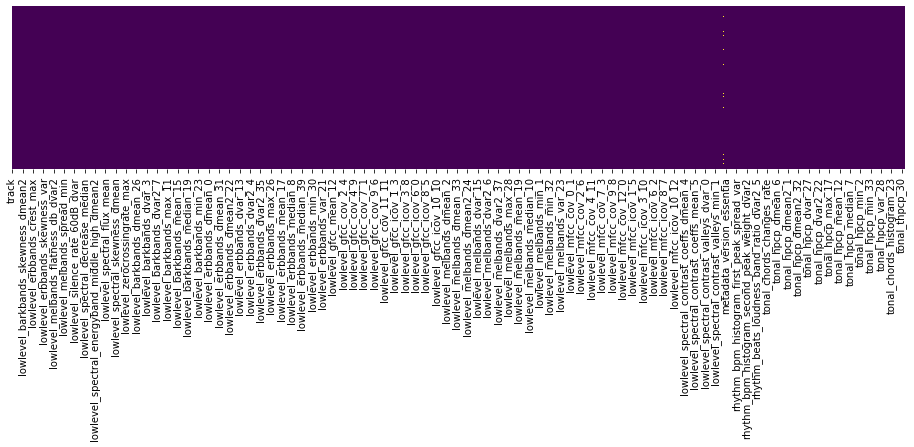

In [49]:
plt.figure(figsize=(16, 3))
sns.heatmap(df_full_tracks.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Config Data

In [50]:
with open("../configuration.yaml") as file:
    config_data = yaml.safe_load(file)

In [51]:
config_data

{'ground_truth_directory': 'datasets',
 'acousticbrainz': False,
 'from_disk': True,
 'class_dir': 'danceability',
 'enumeration_columns': ['tonal_chords_key',
  'tonal_chords_scale',
  'tonal_key_key',
  'tonal_key_scale'],
 'remove_columns': ['json_directory', 'track'],
 'exports_directory': 'exports',
 'evaluations_directory': 'evaluations',
 'tracks_in_csv_format': 'tracks_csv',
 'delete_logs': True,
 'log_directory': 'logs',
 'logging_level': 0,
 'scaling': 'standard_scaled',
 'excludedDescriptors': ['metadata.tags*'],
 'processing': {'raw': [],
  'basic': [{'transfo': 'remove',
    'params': {'descriptorNames': ['metadata.*',
      '*dmean*',
      '*dvar*',
      '*.min',
      '*.max',
      '*cov',
      'tonal.thpcp',
      'lowlevel.spectral_energyband_high.*',
      'lowlevel.silence_rate*']}},
   {'transfo': 'enumerate',
    'params': {'descriptorNames': ['tonal.chords_key',
      'tonal.chords_scale',
      'tonal.key_key',
      'tonal.key_scale']}}],
  'lowlevel': [{'tr

# Functions for features first handling

In [52]:
def list_descr_handler(descr_list):
    """

    :param descr_list:
    :return:
    """
    keys_list_handle = []
    for item in descr_list:
        if item.endswith(".*"):
            item = item.replace(".*", "_")
        elif item.startswith("*."):
            item = item.replace("*.", "_")
        else:
            item = item.replace("*", "")
        item = item.replace(".", "_")
        keys_list_handle.append(item)
    return keys_list_handle

In [53]:
def descr_remover(df, descr_remove_list):
    """

    :param df:
    :param descr_remove_list:
    :return:
    """
    columns_list = list(df.columns)
    columns_del_list = []
    for item in descr_remove_list:
        for del_item in columns_list:
            if re.search(item, del_item):
                columns_del_list.append(del_item)
    df_used_descr = df.drop(columns=columns_del_list, axis=1)
    return df_used_descr

# Clean

In [54]:
def cleaner(config, df):
    cleaning_columns_list = config["excludedDescriptors"]
    cleaning_columns_list = list_descr_handler(cleaning_columns_list)
    print("Cleaner for columns: {}".format(cleaning_columns_list))
    df = descr_remover(df, cleaning_columns_list)
    print("Shape of the df after the data cleaning: \n{}".format(df.shape))
    return df

In [55]:
df_tracks_clean = cleaner(config=config_data, df=df_feats_tracks)

Cleaner for columns: ['metadata_tags']
Shape of the df after the data cleaning: 
(225, 2664)


In [56]:
df_tracks_clean.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_dmean  \
0                   0.901610                        2.851923   
1                   0.949324                        3.174315   
2                   0.913282                        2.181895   
3                   0.445091                        2.068754   
4                   0.972188                        2.960291   

   lowlevel_barkbands_crest_dmean2  lowlevel_barkbands_crest_dvar  \
0                         4.499587                       8.706123   
1                         5.078063                       7.304175   
2                         3.623863                       4.218933   
3                         3.418297                       4.067856   
4                         4.524268                       7.015831   

   lowlevel_barkbands_crest_dvar2  lowlevel_barkbands_crest_max  \
0                       19.547344                     26.821955   
1                       17.572475                     26.197029   
2                       11.479661                     26.548185   
3                       11.059191                     23.429127   
4                       15.027901                     26.545599   

   lowlevel_barkbands_crest_mean  lowlevel_barkbands_crest_median  \
0                      14.598731                        14.511290   
1                      13.199748                        12.578218   
2                       8.336597                         7.740760   
3                       8.549273                         7.936949   
4                      12.708415                        11.376688   

   lowlevel_barkbands_crest_min  lowlevel_barkbands_crest_var  \
0                      2.443070                     29.304781   
1                      3.386296                     22.034767   
2                      2.662538                     10.154660   
3                      2.704834                     10.232707   
4                      2.155651                     30.880127   

   lowlevel_barkbands_flatness_db_dmean  \
0                              0.032417   
1                              0.035071   
2                              0.017883   
3                              0.020813   
4                              0.041673   

   lowlevel_barkbands_flatness_db_dmean2  lowlevel_barkbands_flatness_db_dvar  \
0                               0.049193                             0.001263   
1                               0.047904                             0.001065   
2                               0.027527                             0.000268   
3                               0.030920                             0.000484   
4                               0.055483                             0.001466   

   lowlevel_barkbands_flatness_db_dvar2  lowlevel_barkbands_flatness_db_max  \
0                              0.002893                            0.492411   
1                              0.001887                            0.483815   
2                              0.000640                            0.654950   
3                              0.001116                            0.397568   
4                              0.002553                            0.680143   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.177351                               0.169156   
1                             0.231219                               0.220803   
2                             0.131958                               0.127668   
3                             0.164093                               0.156858   
4                             0.169253                               0.139796   

   lowlevel_barkbands_flatness_db_min  lowlevel_barkbands_flatness_db_var  \
0                            0.031269                            0.004335   
1                            0.069465                            0.005204   
2                            0.023456                  

In [57]:
df_tracks_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 2664 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(2575), int64(79), object(10)
memory usage: 4.6+ MB


# Remove

In [58]:
remove_list = list_descr_handler(config_data["processing"]["normalized"][0]["params"]["descriptorNames"])
print(remove_list)
df_tracks_remove = descr_remover(df_tracks_clean, remove_list)
print("items removed related to: {}".format(remove_list))

['metadata_', 'dmean', 'dvar', '_min', '_max', 'cov', 'tonal_thpcp', 'lowlevel_spectral_energyband_high_', 'lowlevel_silence_rate']
items removed related to: ['metadata_', 'dmean', 'dvar', '_min', '_max', 'cov', 'tonal_thpcp', 'lowlevel_spectral_energyband_high_', 'lowlevel_silence_rate']


In [59]:
df_tracks_remove.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_mean  \
0                   0.901610                      14.598731   
1                   0.949324                      13.199748   
2                   0.913282                       8.336597   
3                   0.445091                       8.549273   
4                   0.972188                      12.708415   

   lowlevel_barkbands_crest_median  lowlevel_barkbands_crest_var  \
0                        14.511290                     29.304781   
1                        12.578218                     22.034767   
2                         7.740760                     10.154660   
3                         7.936949                     10.232707   
4                        11.376688                     30.880127   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.177351                               0.169156   
1                             0.231219                               0.220803   
2                             0.131958                               0.127668   
3                             0.164093                               0.156858   
4                             0.169253                               0.139796   

   lowlevel_barkbands_flatness_db_var  lowlevel_barkbands_kurtosis_mean  \
0                            0.004335                         14.280152   
1                            0.005204                         20.645302   
2                            0.001731                          2.050741   
3                            0.002727                          4.374379   
4                            0.011107                          8.127258   

   lowlevel_barkbands_kurtosis_median  lowlevel_barkbands_kurtosis_var  \
0                            5.195225                       840.732544   
1                            8.765581                      1037.339844   
2                           -0.302823                      1144.171143   
3                            2.359612                        45.072128   
4                            2.346475                       238.589066   

   lowlevel_barkbands_skewness_mean  lowlevel_barkbands_skewness_median  \
0                          2.600330                            2.192480   
1                          3.083442                            2.821217   
2                          0.766083                            0.592710   
3                          1.333631                            1.242853   
4                          2.055088                            1.710526   

   lowlevel_barkbands_skewness_var  lowlevel_barkbands_spread_mean  \
0                         5.281932                       24.735310   
1                         5.642794                       13.094120   
2                         1.804661                       26.486275   
3                         1.402493                       14.422327   
4                         2.863148                       23.595592   

   lowlevel_barkbands_spread_median  lowlevel_barkbands_spread_var  \
0                         19.154926                     418.523499   
1                         10.016789                     135.230972   
2                         25.469574                     131.857101   
3                         12.424109                     106.211952   
4                         19.871262                     311.127502   

   lowlevel_dissonance_mean  lowlevel_dissonance_median  \
0                  0.452440                    0.461502   
1                  0.459848                    0.467818   
2                  0.475011                    0.480130   
3                  0.442273                    0.450466   
4                  0.459030                    0.474789   

   lowlevel_dissonance_var  lowlevel_dynamic_complexity  \
0                 0.001468                     3.828906   
1                 0.000940                     3.553957   
2      

In [60]:
df_tracks_remove.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 679 entries, lowlevel_average_loudness to tonal_key_scale
dtypes: float64(663), int64(12), object(4)
memory usage: 1.2+ MB


# Enumerate

In [61]:
enumerate_list = list_descr_handler(config_data["processing"]["normalized"][1]["params"]["descriptorNames"])

In [62]:
print(enumerate_list)

['tonal_chords_key', 'tonal_chords_scale', 'tonal_key_key', 'tonal_key_scale']


In [63]:
df_tracks_cat = df_tracks_remove[enumerate_list]

In [64]:
df_tracks_cat.head()

tonal_chords_key tonal_chords_scale tonal_key_key tonal_key_scale
0               G#              major            C#           major
1                G              major             G           major
2                G              minor             G           major
3                G              major             G           major
4                G              major             A           minor

In [65]:
df_tracks_num = df_tracks_remove.drop(columns=enumerate_list, axis=1)

In [66]:
df_tracks_num.head()

lowlevel_average_loudness  lowlevel_barkbands_crest_mean  \
0                   0.901610                      14.598731   
1                   0.949324                      13.199748   
2                   0.913282                       8.336597   
3                   0.445091                       8.549273   
4                   0.972188                      12.708415   

   lowlevel_barkbands_crest_median  lowlevel_barkbands_crest_var  \
0                        14.511290                     29.304781   
1                        12.578218                     22.034767   
2                         7.740760                     10.154660   
3                         7.936949                     10.232707   
4                        11.376688                     30.880127   

   lowlevel_barkbands_flatness_db_mean  lowlevel_barkbands_flatness_db_median  \
0                             0.177351                               0.169156   
1                             0.231219                               0.220803   
2                             0.131958                               0.127668   
3                             0.164093                               0.156858   
4                             0.169253                               0.139796   

   lowlevel_barkbands_flatness_db_var  lowlevel_barkbands_kurtosis_mean  \
0                            0.004335                         14.280152   
1                            0.005204                         20.645302   
2                            0.001731                          2.050741   
3                            0.002727                          4.374379   
4                            0.011107                          8.127258   

   lowlevel_barkbands_kurtosis_median  lowlevel_barkbands_kurtosis_var  \
0                            5.195225                       840.732544   
1                            8.765581                      1037.339844   
2                           -0.302823                      1144.171143   
3                            2.359612                        45.072128   
4                            2.346475                       238.589066   

   lowlevel_barkbands_skewness_mean  lowlevel_barkbands_skewness_median  \
0                          2.600330                            2.192480   
1                          3.083442                            2.821217   
2                          0.766083                            0.592710   
3                          1.333631                            1.242853   
4                          2.055088                            1.710526   

   lowlevel_barkbands_skewness_var  lowlevel_barkbands_spread_mean  \
0                         5.281932                       24.735310   
1                         5.642794                       13.094120   
2                         1.804661                       26.486275   
3                         1.402493                       14.422327   
4                         2.863148                       23.595592   

   lowlevel_barkbands_spread_median  lowlevel_barkbands_spread_var  \
0                         19.154926                     418.523499   
1                         10.016789                     135.230972   
2                         25.469574                     131.857101   
3                         12.424109                     106.211952   
4                         19.871262                     311.127502   

   lowlevel_dissonance_mean  lowlevel_dissonance_median  \
0                  0.452440                    0.461502   
1                  0.459848                    0.467818   
2                  0.475011                    0.480130   
3                  0.442273                    0.450466   
4                  0.459030                    0.474789   

   lowlevel_dissonance_var  lowlevel_dynamic_complexity  \
0                 0.001468                     3.828906   
1                 0.000940                     3.553957   
2      

In [67]:
num_list = list(df_tracks_num.columns)

In [68]:
len(num_list)

675

In [69]:
df_tracks_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 675 entries, lowlevel_average_loudness to tonal_chords_histogram_23
dtypes: float64(663), int64(12)
memory usage: 1.2 MB


In [70]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, QuantileTransformer

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [72]:
cat_attribs = enumerate_list
num_attribs = num_list

In [73]:
from sklearn.pipeline import Pipeline

In [74]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('minmax_scaler', MinMaxScaler())
])

In [75]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [76]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [77]:
tracks_prepared = full_pipeline.fit_transform(df_tracks_remove)

In [78]:
tracks_prepared.shape

(225, 703)

# Train

In [79]:
config_data["classifiers"]["svm"][0]

{'preprocessing': ['basic',
  'lowlevel',
  'nobands',
  'normalized',
  'gaussianized'],
 'type': ['C-SVC'],
 'kernel': ['poly', 'RBF'],
 'C': [-5, -3, -1, 1, 3, 5, 7, 9, 11],
 'gamma': [3, 1, -1, -3, -5, -7, -9, -11],
 'balanceClasses': [False, True]}

In [80]:
c = config_data["classifiers"]["svm"][0]["C"]
c = [2 ** x for x in c]
c

[0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048]

In [81]:
gamma = config_data["classifiers"]["svm"][0]["gamma"]
gamma = [2 ** x for x in gamma]
gamma

[8, 2, 0.5, 0.125, 0.03125, 0.0078125, 0.001953125, 0.00048828125]

In [82]:
# define the length of parameters
parameters_grid = {'kernel': ['poly', 'rbf'],
                   'C': c,
                   'gamma': gamma,
                   'class_weight': [None, "balanced"]
                   }

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [84]:
svc = SVC(probability=True)

In [85]:
from sklearn.model_selection import KFold

In [86]:
inner_cv = KFold(n_splits=5,
                 shuffle=False
                )

In [87]:
clf = GridSearchCV(svc, parameters_grid, cv=inner_cv, n_jobs=-1, verbose=2)

In [88]:
y = df_tracks["danceability"]

In [89]:
y.head()

0        danceable
1        danceable
2    not_danceable
3    not_danceable
4        danceable
Name: danceability, dtype: object

In [90]:
y_array = y.to_numpy()

In [91]:
y_array[:3]

array(['danceable', 'danceable', 'not_danceable'], dtype=object)

In [92]:
clf.fit(tracks_prepared, y_array)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1160 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   24.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048],
                         'class_weight': [None, 'balanced'],
                         'gamma': [8, 2, 0.5, 0.125, 0.03125, 0.0078125,
                                   0.001953125, 0.00048828125],
                         'kernel': ['poly', 'rbf']},
             verbose=2)

In [93]:
clf.best_estimator_

SVC(C=128, gamma=0.001953125, probability=True)

In [94]:
clf.best_params_

{'C': 128, 'class_weight': None, 'gamma': 0.001953125, 'kernel': 'rbf'}

In [95]:
import math

In [96]:
math.log2(clf.best_params_["C"])

7.0

In [97]:
math.log2(clf.best_params_["gamma"])

-9.0

# Evaluate

In [98]:
predictions = clf.predict(tracks_prepared)

In [99]:
from sklearn.metrics import confusion_matrix, classification_report

In [100]:
cm = confusion_matrix(y_true=y, y_pred=predictions)

In [101]:
cm

array([[144,   0],
       [  0,  81]])

In [102]:
cm_normalized = (cm / cm.astype(np.float).sum(axis=1) * 100)

In [103]:
cm_normalized

array([[100.,   0.],
       [  0., 100.]])

In [104]:
print(classification_report(y_true=y, y_pred=predictions))

               precision    recall  f1-score   support

    danceable       1.00      1.00      1.00       144
not_danceable       1.00      1.00      1.00        81

     accuracy                           1.00       225
    macro avg       1.00      1.00      1.00       225
 weighted avg       1.00      1.00      1.00       225



In [105]:
svm = clf.best_estimator_

In [106]:
svm.fit(tracks_prepared, y)

SVC(C=128, gamma=0.001953125, probability=True)

In [107]:
predictions_model = svm.predict(tracks_prepared)

In [108]:
cm_model = confusion_matrix(y_true=y, y_pred=predictions_model)

In [109]:
cm_model

array([[144,   0],
       [  0,  81]])

In [110]:
cm_model_normalized = (cm_model / cm_model.astype(np.float).sum(axis=1) * 100)

In [111]:
cm_model_normalized

array([[100.,   0.],
       [  0., 100.]])

In [112]:
print(classification_report(y_true=y, y_pred=predictions_model))

               precision    recall  f1-score   support

    danceable       1.00      1.00      1.00       144
not_danceable       1.00      1.00      1.00        81

     accuracy                           1.00       225
    macro avg       1.00      1.00      1.00       225
 weighted avg       1.00      1.00      1.00       225



# Save/Load Pipeline

In [113]:
import joblib

In [114]:
joblib.dump(full_pipeline, "full_pipeline.pkl")

['full_pipeline.pkl']

In [115]:
joblib.dump(clf.best_estimator_, "model_saved.pkl")

['model_saved.pkl']

In [116]:
model_load = joblib.load("model_saved.pkl")

In [117]:
pipeline_load = joblib.load("full_pipeline.pkl")

# KFold Validation to the whole dataset (more and more tests)

## Evaluating estimator performance (best grid model)

In [118]:
from sklearn.model_selection import cross_val_score

In [119]:
svm = clf.best_estimator_

In [120]:
scores = cross_val_score(svm, tracks_prepared, y, cv=inner_cv)

In [121]:
scores

array([0.91111111, 0.97777778, 0.97777778, 0.95555556, 0.91111111])

In [122]:
print("Accuracy: {} (+/- {})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.9466666666666667 (+/- 0.06028737762778016)


## Loaded best grid model

In [123]:
svm_2 = model_load

In [124]:
scores = cross_val_score(svm, tracks_prepared, y, cv=inner_cv)

In [125]:
scores

array([0.91111111, 0.97777778, 0.97777778, 0.95555556, 0.91111111])

In [126]:
print("Accuracy: {} (+/- {})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.9466666666666667 (+/- 0.06028737762778016)


## Folds train

In [127]:
accuracy_model = []
predictions_df_list = []
fold_number = 0

In [128]:
from termcolor import colored

In [129]:
from sklearn.metrics import accuracy_score

In [130]:
for train_index, test_index in inner_cv.split(tracks_prepared):
    print("Fold: {}".format(fold_number))
    # print("TRAIN INDEX: ", train_index)
    print("first test index element: {} - last test index element: {}".format(test_index[0], test_index[-1]))
    print(colored("Length of the train index array: {}".format(len(train_index)), "cyan"))
    print(colored("Length of the test index array: {}".format(len(test_index)), "cyan"))
    X_train, X_test = tracks_prepared[train_index], tracks_prepared[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Train the model
    svm.fit(X_train, y_train)
    print("Classifier classes: {}".format(svm.classes_))
    # Append to accuracy_model the accuracy of the model
    accuracy_model.append(accuracy_score(y_test, svm.predict(X_test), normalize=True) * 100)
    fold_number += 1

Fold: 0
first test index element: 0 - last test index element: 44
Length of the train index array: 180
Length of the test index array: 45
Classifier classes: ['danceable' 'not_danceable']
Fold: 1
first test index element: 45 - last test index element: 89
Length of the train index array: 180
Length of the test index array: 45
Classifier classes: ['danceable' 'not_danceable']
Fold: 2
first test index element: 90 - last test index element: 134
Length of the train index array: 180
Length of the test index array: 45
Classifier classes: ['danceable' 'not_danceable']
Fold: 3
first test index element: 135 - last test index element: 179
Length of the train index array: 180
Length of the test index array: 45
Classifier classes: ['danceable' 'not_danceable']
Fold: 4
first test index element: 180 - last test index element: 224
Length of the train index array: 180
Length of the test index array: 45
Classifier classes: ['danceable' 'not_danceable']


In [131]:
print(colored("Accuracies in each fold: {}".format(accuracy_model), "blue"))
print(colored("Mean of accuracies: {}".format(np.mean(accuracy_model)), "blue"))
print(colored("Standard Deviation of accuracies: {}".format(np.std(accuracy_model)), "blue"))

Accuracies in each fold: [91.11111111111111, 97.77777777777777, 97.77777777777777, 95.55555555555556, 91.11111111111111]
Mean of accuracies: 94.66666666666666
Standard Deviation of accuracies: 3.0143688813890037


# Fit/Evaluate to the whole dataset

In [132]:
# train with all the data
print(colored("Evaluation to the whole dataset..", "cyan"))
svm.fit(tracks_prepared, y)
predictions_proba_all = svm.predict_proba(tracks_prepared)
predictions_all = svm.predict(tracks_prepared)
print(colored("Confusion Matrix All:", "magenta"))
cm_all = confusion_matrix(y_true=y, y_pred=predictions_all)
print(cm_all)
print(colored("Confusion Matrix All Normalized:", "magenta"))
cm_all_normalized = (cm_all / cm_all.astype(np.float).sum(axis=1) * 100)
print(cm_all_normalized)
print(colored("Classification Report All:", "magenta"))
cr_all = classification_report(y_true=y, y_pred=predictions_all)
print(cr_all)

Evaluation to the whole dataset..
Confusion Matrix All:
[[144   0]
 [  0  81]]
Confusion Matrix All Normalized:
[[100.   0.]
 [  0. 100.]]
Classification Report All:
               precision    recall  f1-score   support

    danceable       1.00      1.00      1.00       144
not_danceable       1.00      1.00      1.00        81

     accuracy                           1.00       225
    macro avg       1.00      1.00      1.00       225
 weighted avg       1.00      1.00      1.00       225



# Predict

## Predict with the existing classifier

In [133]:
import requests

In [134]:
# "Idle Up" by Dousk & JMP - danceable
# response = requests.get('https://acousticbrainz.org/api/v1/78281677-8ba1-41df-b0f7-df6b024caf13/low-level')

# "Born Slippy" by Underworld - danceable
# response = requests.get('https://acousticbrainz.org/api/v1/78281677-8ba1-41df-b0f7-df6b024caf13/low-level')

# "So Dear to My Heart" by Peggy Lee - not danceable
# response = requests.get('https://acousticbrainz.org/api/v1/7fb1b586-017c-4a89-b15a-0bb837983108/low-level')

# "Shy Guy" by Frankie Avalon - not danceable
# response = requests.get('https://acousticbrainz.org/api/v1/932162fd-21fe-4a69-aaff-5a2cca92bd8d/low-level')


In [135]:
response = requests.get('https://acousticbrainz.org/api/v1/78281677-8ba1-41df-b0f7-df6b024caf13/low-level')

In [136]:
track = response.json()

In [137]:
# track

In [138]:
track["metadata"]["tags"]["artist"][0]

'Dousk & JMP'

In [139]:
list_feats_track = []

In [140]:
# remove unnecessary data
if 'beats_position' in track['rhythm']:
  del track['rhythm']['beats_position']

# data dictionary transformed to a fully flattened dictionary
data_feats_track = flatten_dict_full(track)

# append to a full tracks features pandas df
list_feats_track.append(dict(data_feats_track))

In [141]:
df_track = pd.DataFrame(data=list_feats_track, columns=list(list_feats_track[0].keys()))

In [142]:
df_track

lowlevel_average_loudness  lowlevel_barkbands_dmean_0  \
0                   0.946418                    0.000953   

   lowlevel_barkbands_dmean_1  lowlevel_barkbands_dmean_2  \
0                    0.021288                    0.006133   

   lowlevel_barkbands_dmean_3  lowlevel_barkbands_dmean_4  \
0                    0.003094                    0.004926   

   lowlevel_barkbands_dmean_5  lowlevel_barkbands_dmean_6  \
0                    0.000724                    0.000677   

   lowlevel_barkbands_dmean_7  lowlevel_barkbands_dmean_8  \
0                    0.000191                    0.000157   

   lowlevel_barkbands_dmean_9  lowlevel_barkbands_dmean_10  \
0                    0.000219                     0.000322   

   lowlevel_barkbands_dmean_11  lowlevel_barkbands_dmean_12  \
0                     0.000237                     0.000241   

   lowlevel_barkbands_dmean_13  lowlevel_barkbands_dmean_14  \
0                     0.000149                     0.000156   

   lowlevel_barkbands_dmean_15  lowlevel_barkbands_dmean_16  \
0                      0.00011                     0.000101   

   lowlevel_barkbands_dmean_17  lowlevel_barkbands_dmean_18  \
0                     0.000112                     0.000175   

   lowlevel_barkbands_dmean_19  lowlevel_barkbands_dmean_20  \
0                     0.000218                     0.000289   

   lowlevel_barkbands_dmean_21  lowlevel_barkbands_dmean_22  \
0                     0.000345                     0.000404   

   lowlevel_barkbands_dmean_23  lowlevel_barkbands_dmean_24  \
0                     0.000488                     0.000499   

   lowlevel_barkbands_dmean_25  lowlevel_barkbands_dmean_26  \
0                     0.000295                     0.000038   

   lowlevel_barkbands_dmean2_0  lowlevel_barkbands_dmean2_1  \
0                     0.000988                     0.020504   

   lowlevel_barkbands_dmean2_2  lowlevel_barkbands_dmean2_3  \
0                     0.010418                     0.005515   

   lowlevel_barkbands_dmean2_4  lowlevel_barkbands_dmean2_5  \
0                     0.009261                     0.001292   

   lowlevel_barkbands_dmean2_6  lowlevel_barkbands_dmean2_7  \
0                     0.001102                     0.000315   

   lowlevel_barkbands_dmean2_8  lowlevel_barkbands_dmean2_9  \
0                     0.000263                     0.000364   

   lowlevel_barkbands_dmean2_10  lowlevel_barkbands_dmean2_11  \
0                      0.000524                      0.000389   

   lowlevel_barkbands_dmean2_12  lowlevel_barkbands_dmean2_13  \
0                      0.000394                       0.00025   

   lowlevel_barkbands_dmean2_14  lowlevel_barkbands_dmean2_15  \
0                      0.000259                      0.000173   

   lowlevel_barkbands_dmean2_16  lowlevel_barkbands_dmean2_17  \
0                      0.000157                      0.000173   

   lowlevel_barkbands_dmean2_18  lowlevel_barkbands_dmean2_19  \
0                      0.000251                      0.000331   

   lowlevel_barkbands_dmean2_20  lowlevel_barkbands_dmean2_21  \
0                      0.000386                      0.000479   

   lowlevel_barkbands_dmean2_22  lowlevel_barkbands_dmean2_23  \
0                      0.000634                       0.00064   

   lowlevel_barkbands_dmean2_24  lowlevel_barkbands_dmean2_25  \
0                      0.000697                      0.000407   

   lowlevel_barkbands_dmean2_26  lowlevel_barkbands_dvar_0  \
0                      0.000046                   0.000003   

   lowlevel_barkbands_dvar_1  lowlevel_barkbands_dvar_2  \
0                    0.00157                   0.000288   

   lowlevel_barkbands_dvar_3  lowlevel_barkbands_dvar_4  \
0                   0.000076                   0.000265   

   lowlevel_barkbands_dvar_5  lowlevel_barkbands_dvar_6  \
0                   0.000003                   0.000003   

   lowlevel_barkbands_dvar_7  lowlevel_barkbands_dvar_8  \
0               2.449192e

In [143]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 2689 entries, lowlevel_average_loudness to tonal_tuning_nontempered_energy_ratio
dtypes: bool(1), float64(2510), int64(143), object(35)
memory usage: 21.1+ KB


In [144]:
df_track_clean = cleaner(config=config_data, df=df_track)

Cleaner for columns: ['metadata_tags']
Shape of the df after the data cleaning: 
(1, 2665)


In [145]:
df_track_remove = descr_remover(df_track_clean, remove_list)

In [146]:
df_track_remove.head()

lowlevel_average_loudness  lowlevel_barkbands_mean_0  \
0                   0.946418                   0.001943   

   lowlevel_barkbands_mean_1  lowlevel_barkbands_mean_2  \
0                   0.050012                   0.005576   

   lowlevel_barkbands_mean_3  lowlevel_barkbands_mean_4  \
0                   0.002772                   0.003245   

   lowlevel_barkbands_mean_5  lowlevel_barkbands_mean_6  \
0                   0.000577                   0.000648   

   lowlevel_barkbands_mean_7  lowlevel_barkbands_mean_8  \
0                     0.0002                   0.000153   

   lowlevel_barkbands_mean_9  lowlevel_barkbands_mean_10  \
0                   0.000216                    0.000362   

   lowlevel_barkbands_mean_11  lowlevel_barkbands_mean_12  \
0                    0.000247                    0.000271   

   lowlevel_barkbands_mean_13  lowlevel_barkbands_mean_14  \
0                    0.000172                    0.000182   

   lowlevel_barkbands_mean_15  lowlevel_barkbands_mean_16  \
0                     0.00013                    0.000139   

   lowlevel_barkbands_mean_17  lowlevel_barkbands_mean_18  \
0                    0.000151                    0.000213   

   lowlevel_barkbands_mean_19  lowlevel_barkbands_mean_20  \
0                    0.000263                    0.000349   

   lowlevel_barkbands_mean_21  lowlevel_barkbands_mean_22  \
0                    0.000428                    0.000534   

   lowlevel_barkbands_mean_23  lowlevel_barkbands_mean_24  \
0                    0.000662                    0.000658   

   lowlevel_barkbands_mean_25  lowlevel_barkbands_mean_26  \
0                    0.000389                     0.00005   

   lowlevel_barkbands_median_0  lowlevel_barkbands_median_1  \
0                     0.000124                     0.011925   

   lowlevel_barkbands_median_2  lowlevel_barkbands_median_3  \
0                      0.00055                      0.00038   

   lowlevel_barkbands_median_4  lowlevel_barkbands_median_5  \
0                     0.000369                     0.000096   

   lowlevel_barkbands_median_6  lowlevel_barkbands_median_7  \
0                     0.000085                     0.000027   

   lowlevel_barkbands_median_8  lowlevel_barkbands_median_9  \
0                      0.00001                     0.000012   

   lowlevel_barkbands_median_10  lowlevel_barkbands_median_11  \
0                      0.000013                      0.000012   

   lowlevel_barkbands_median_12  lowlevel_barkbands_median_13  \
0                      0.000018                      0.000021   

   lowlevel_barkbands_median_14  lowlevel_barkbands_median_15  \
0                      0.000016                      0.000012   

   lowlevel_barkbands_median_16  lowlevel_barkbands_median_17  \
0                      0.000024                      0.000025   

   lowlevel_barkbands_median_18  lowlevel_barkbands_median_19  \
0                      0.000033                      0.000051   

   lowlevel_barkbands_median_20  lowlevel_barkbands_median_21  \
0                      0.000043                      0.000066   

   lowlevel_barkbands_median_22  lowlevel_barkbands_median_23  \
0                      0.000101                      0.000131   

   lowlevel_barkbands_median_24  lowlevel_barkbands_median_25  \
0                      0.000166                      0.000057   

   lowlevel_barkbands_median_26  lowlevel_barkbands_var_0  \
0                      0.000001                  0.000013   

   lowlevel_barkbands_var_1  lowlevel_barkbands_var_2  \
0                  0.007475                   0.00022   

   lowlevel_barkbands_var_3  lowlevel_barkbands_var_4  \
0                   0.00005                  0.000146   

   lowlevel_barkbands_var_5  lowlevel_barkbands_var_6  \
0                  0.000002                  0.000002   

   lowlevel_barkbands_var_7  lowlevel_barkbands_var_8  \
0              3.150895e-07              2.131110e-07   

   lowlevel_barkbands_var_9  lowlevel

In [147]:
df_track_remove.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 679 entries, lowlevel_average_loudness to tonal_tuning_nontempered_energy_ratio
dtypes: float64(653), int64(22), object(4)
memory usage: 5.4+ KB


In [148]:
track_pred = full_pipeline.transform(df_track_remove)

In [149]:
track_pred.shape

(1, 703)

In [150]:
clf.predict(track_pred)

array(['danceable'], dtype=object)

In [151]:
clf.classes_

array(['danceable', 'not_danceable'], dtype=object)

In [152]:
clf.predict_proba(track_pred)

array([[9.99997847e-01, 2.15254937e-06]])

In [153]:
pred_tr = clf.predict_proba(track_pred)

In [154]:
np.around(pred_tr * 100)

array([[100.,   0.]])

## Predict with the loaded classifier

In [155]:
track_feats_new_test = df_track_remove

In [156]:
track_feats_new_test

lowlevel_average_loudness  lowlevel_barkbands_mean_0  \
0                   0.946418                   0.001943   

   lowlevel_barkbands_mean_1  lowlevel_barkbands_mean_2  \
0                   0.050012                   0.005576   

   lowlevel_barkbands_mean_3  lowlevel_barkbands_mean_4  \
0                   0.002772                   0.003245   

   lowlevel_barkbands_mean_5  lowlevel_barkbands_mean_6  \
0                   0.000577                   0.000648   

   lowlevel_barkbands_mean_7  lowlevel_barkbands_mean_8  \
0                     0.0002                   0.000153   

   lowlevel_barkbands_mean_9  lowlevel_barkbands_mean_10  \
0                   0.000216                    0.000362   

   lowlevel_barkbands_mean_11  lowlevel_barkbands_mean_12  \
0                    0.000247                    0.000271   

   lowlevel_barkbands_mean_13  lowlevel_barkbands_mean_14  \
0                    0.000172                    0.000182   

   lowlevel_barkbands_mean_15  lowlevel_barkbands_mean_16  \
0                     0.00013                    0.000139   

   lowlevel_barkbands_mean_17  lowlevel_barkbands_mean_18  \
0                    0.000151                    0.000213   

   lowlevel_barkbands_mean_19  lowlevel_barkbands_mean_20  \
0                    0.000263                    0.000349   

   lowlevel_barkbands_mean_21  lowlevel_barkbands_mean_22  \
0                    0.000428                    0.000534   

   lowlevel_barkbands_mean_23  lowlevel_barkbands_mean_24  \
0                    0.000662                    0.000658   

   lowlevel_barkbands_mean_25  lowlevel_barkbands_mean_26  \
0                    0.000389                     0.00005   

   lowlevel_barkbands_median_0  lowlevel_barkbands_median_1  \
0                     0.000124                     0.011925   

   lowlevel_barkbands_median_2  lowlevel_barkbands_median_3  \
0                      0.00055                      0.00038   

   lowlevel_barkbands_median_4  lowlevel_barkbands_median_5  \
0                     0.000369                     0.000096   

   lowlevel_barkbands_median_6  lowlevel_barkbands_median_7  \
0                     0.000085                     0.000027   

   lowlevel_barkbands_median_8  lowlevel_barkbands_median_9  \
0                      0.00001                     0.000012   

   lowlevel_barkbands_median_10  lowlevel_barkbands_median_11  \
0                      0.000013                      0.000012   

   lowlevel_barkbands_median_12  lowlevel_barkbands_median_13  \
0                      0.000018                      0.000021   

   lowlevel_barkbands_median_14  lowlevel_barkbands_median_15  \
0                      0.000016                      0.000012   

   lowlevel_barkbands_median_16  lowlevel_barkbands_median_17  \
0                      0.000024                      0.000025   

   lowlevel_barkbands_median_18  lowlevel_barkbands_median_19  \
0                      0.000033                      0.000051   

   lowlevel_barkbands_median_20  lowlevel_barkbands_median_21  \
0                      0.000043                      0.000066   

   lowlevel_barkbands_median_22  lowlevel_barkbands_median_23  \
0                      0.000101                      0.000131   

   lowlevel_barkbands_median_24  lowlevel_barkbands_median_25  \
0                      0.000166                      0.000057   

   lowlevel_barkbands_median_26  lowlevel_barkbands_var_0  \
0                      0.000001                  0.000013   

   lowlevel_barkbands_var_1  lowlevel_barkbands_var_2  \
0                  0.007475                   0.00022   

   lowlevel_barkbands_var_3  lowlevel_barkbands_var_4  \
0                   0.00005                  0.000146   

   lowlevel_barkbands_var_5  lowlevel_barkbands_var_6  \
0                  0.000002                  0.000002   

   lowlevel_barkbands_var_7  lowlevel_barkbands_var_8  \
0              3.150895e-07              2.131110e-07   

   lowlevel_barkbands_var_9  lowlevel

In [157]:
track_pred_new = pipeline_load.transform(df_track_remove)

In [158]:
track_pred_new.shape

(1, 703)

In [159]:
model_load.predict(track_pred_new)

array(['danceable'], dtype=object)

In [160]:
model_load.classes_

array(['danceable', 'not_danceable'], dtype=object)

In [161]:
model_load.predict_proba(track_pred_new)

array([[9.99990886e-01, 9.11378617e-06]])

# Finish

In [162]:
from datetime import datetime

In [163]:
print("last evaluation run at: {}".format(datetime.now()))

last evaluation run at: 2020-07-27 11:09:53.190946
